In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
machine_id = "m_1932"   # replace with the exact one you saw

In [14]:

data = []

df_iter = pd.read_csv(
    "machine_usage.csv",
    names=[
        "machine_id","timestamp","cpu_util","mem_util",
        "c5","c6","c7","c8","c9"
    ],
    header=None,
    usecols=["machine_id","timestamp","cpu_util","mem_util"],
    chunksize=500_000
)

for chunk in df_iter:
    filtered = chunk[chunk["machine_id"] == machine_id]
    if not filtered.empty:
        data.append(filtered)

df = pd.concat(data)
df = df.sort_values("timestamp")

In [18]:
df.head()

,machine_id,timestamp,cpu_util,mem_util
164621797,m_1932,3410,19,90
54877401,m_1932,3420,20,91
137196220,m_1932,3430,20,91
190899838,m_1932,3440,20,91
82316516,m_1932,3450,20,91


In [16]:
df.tail()


,machine_id,timestamp,cpu_util,mem_util
109753412,m_1932,691150,92,95
109756669,m_1932,691160,93,95
205212809,m_1932,691170,93,94
190913743,m_1932,691180,93,94
109753413,m_1932,691190,92,94


In [17]:
df.shape


(61570, 4)

<Axes: xlabel='timestamp'>

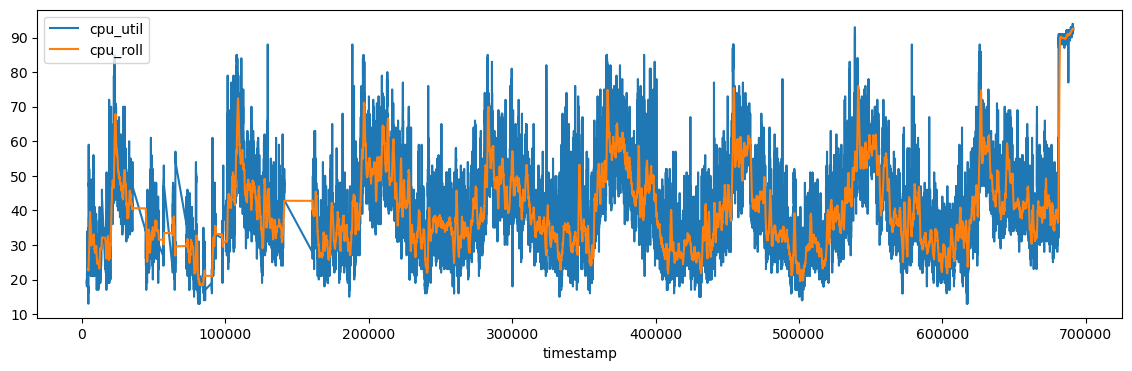

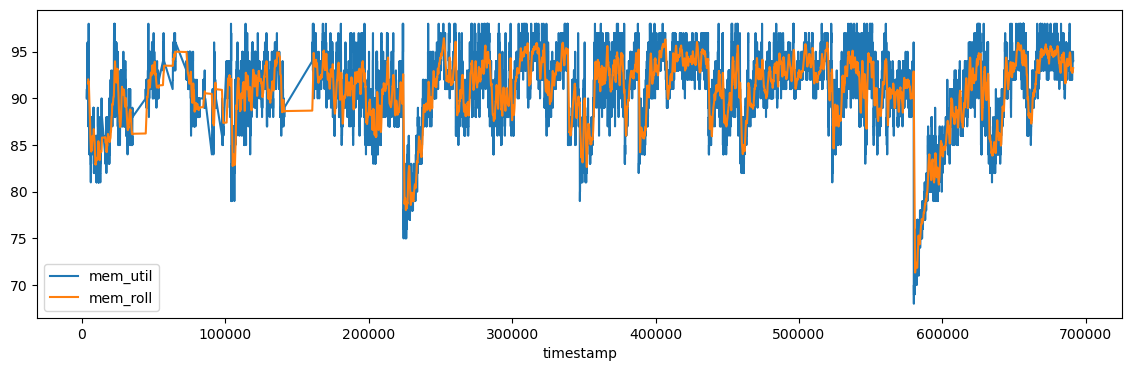

In [20]:
window = 100  # do not tune yet

df["cpu_roll"] = df["cpu_util"].rolling(window).mean()
df["mem_roll"] = df["mem_util"].rolling(window).mean()

df.plot(x="timestamp", y=["cpu_util", "cpu_roll"], figsize=(14,4))
df.plot(x="timestamp", y=["mem_util", "mem_roll"], figsize=(14,4))

<Axes: xlabel='timestamp'>

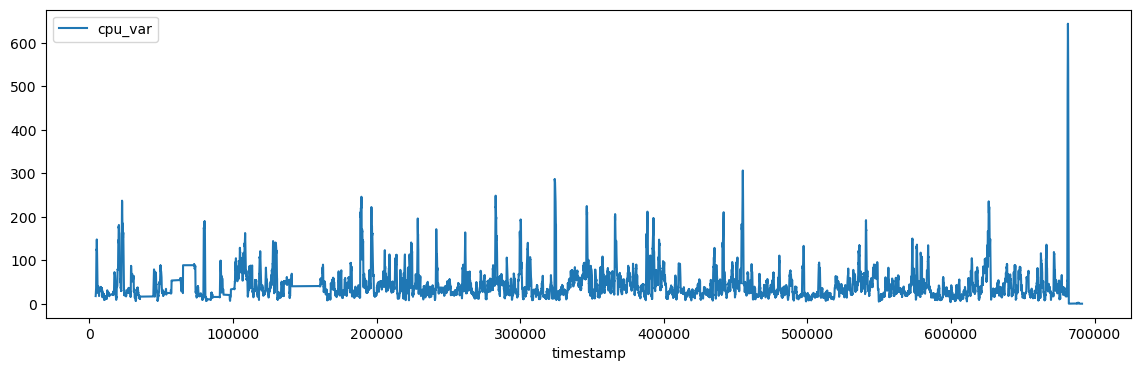

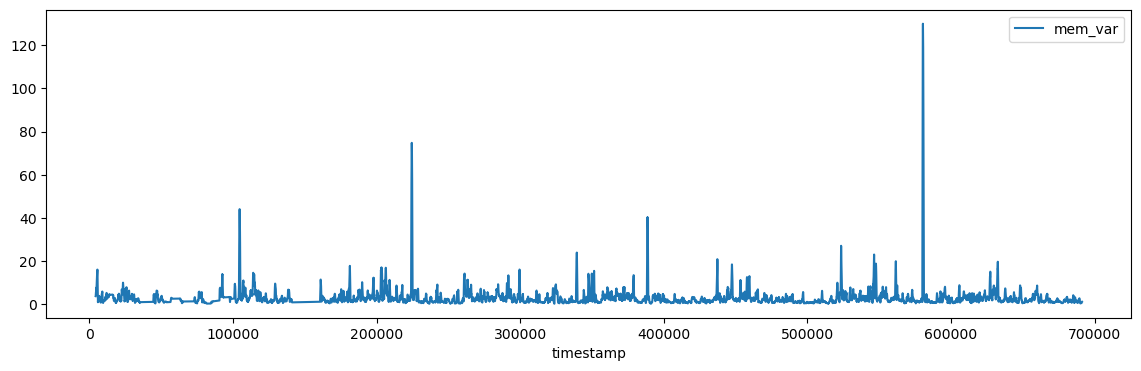

In [21]:
df["cpu_var"] = df["cpu_util"].rolling(window).var()
df["mem_var"] = df["mem_util"].rolling(window).var()

df.plot(x="timestamp", y="cpu_var", figsize=(14,4))
df.plot(x="timestamp", y="mem_var", figsize=(14,4))

STEP 1 — PICK A BASELINE WINDOW

In [22]:
baseline = df[df["timestamp"] < 150_000]

STEP 2 — CAPTURE NORMAL BEHAVIOR (THIS IS THE BASELINE)

In [23]:
baseline_stats = {
    "cpu_mean": baseline["cpu_util"].mean(),
    "cpu_var": baseline["cpu_util"].var(),
    "mem_mean": baseline["mem_util"].mean(),
    "mem_var": baseline["mem_util"].var(),
}

baseline_stats

{'cpu_mean': np.float64(38.05960116513556),
 'cpu_var': 153.42232965604038,
 'mem_mean': np.float64(89.87149899170961),
 'mem_var': 11.434353988065915}

STEP 3 — DEFINE DEVIATION SCORES

deviation = |current_stat − baseline_stat|

In [30]:
df["cpu_mean_dev"] = abs(df["cpu_roll"] - baseline_stats["cpu_mean"])
df["cpu_var_dev"]  = abs(df["cpu_var"]  - baseline_stats["cpu_var"])

df["mem_mean_dev"] = abs(df["mem_roll"] - baseline_stats["mem_mean"])
df["mem_var_dev"]  = abs(df["mem_var"]  - baseline_stats["mem_var"])

STEP 4 — VISUALIZE DEVIATION

<Axes: xlabel='timestamp'>

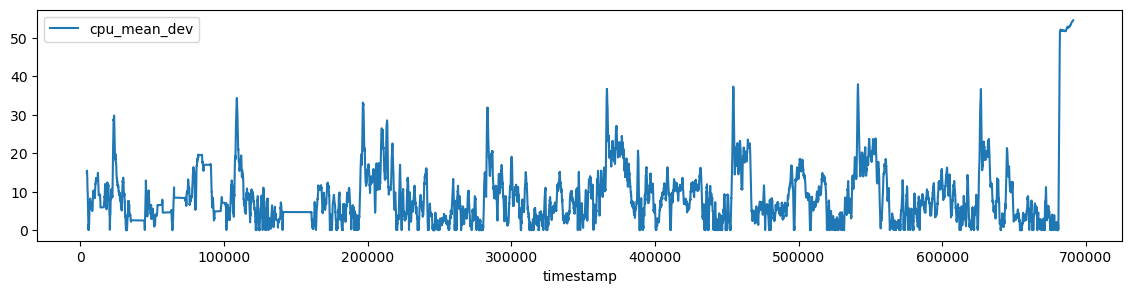

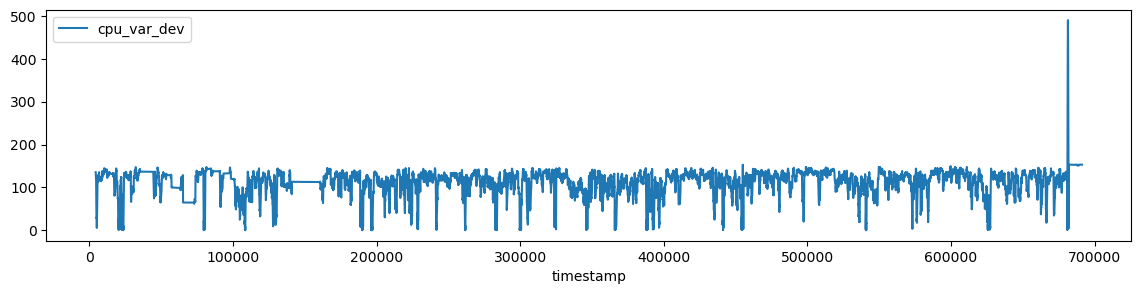

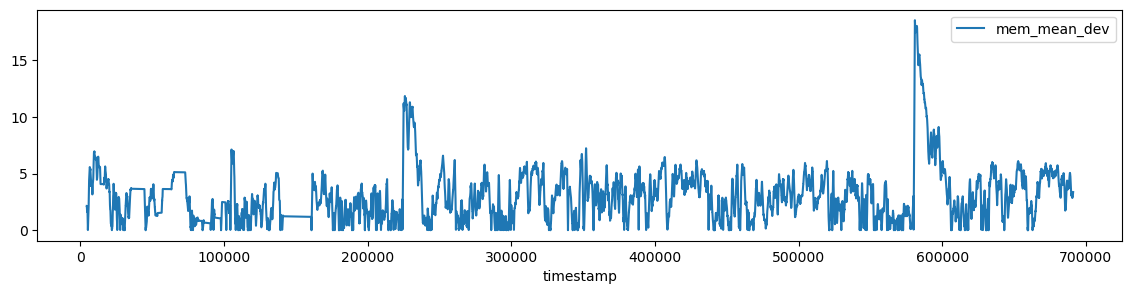

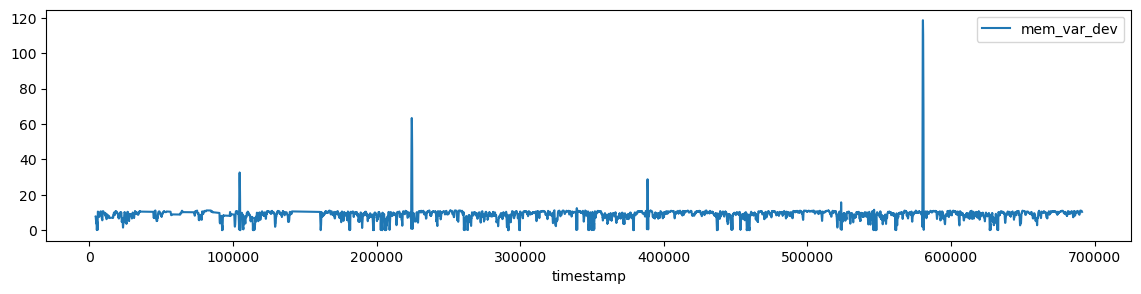

In [31]:
df.plot(x="timestamp", y="cpu_mean_dev", figsize=(14,3))
df.plot(x="timestamp", y="cpu_var_dev", figsize=(14,3))

df.plot(x="timestamp", y="mem_mean_dev", figsize=(14,3))
df.plot(x="timestamp", y="mem_var_dev", figsize=(14,3))

Decide whether the system is NORMAL, UNSTABLE, or SHIFTED based on persistent deviation, not spikes.

In [32]:
mem_var_baseline = baseline_stats["mem_var"]
mem_mean_baseline = baseline_stats["mem_mean"]

In [33]:
df["mem_var_high"] = df["mem_var"] > (2 * mem_var_baseline)
df["mem_mean_high"] = abs(df["mem_roll"] - mem_mean_baseline) > (2 * baseline_stats["mem_var"]**0.5)

In [34]:
PERSIST_WINDOW = 50

In [35]:
df["mem_var_persistent"] = (
    df["mem_var_high"]
    .rolling(PERSIST_WINDOW)
    .sum()
    >= PERSIST_WINDOW
)

df["mem_mean_persistent"] = (
    df["mem_mean_high"]
    .rolling(PERSIST_WINDOW)
    .sum()
    >= PERSIST_WINDOW
)

DEFINE SYSTEM STATES

In [36]:
def assign_state(row):
    if row["mem_var_persistent"] and row["mem_mean_persistent"]:
        return "SHIFTED"
    elif row["mem_var_persistent"] or row["mem_mean_persistent"]:
        return "UNSTABLE"
    else:
        return "NORMAL"

df["state"] = df.apply(assign_state, axis=1)

In [37]:
df[df["state"] != "NORMAL"][["timestamp", "state"]].head(20)

,timestamp,state
246928534,9830,UNSTABLE
190899907,9840,UNSTABLE
82316581,9850,UNSTABLE
164621871,9860,UNSTABLE
177762355,104800,UNSTABLE
246929037,104810,UNSTABLE
164622437,104820,UNSTABLE
246929038,104830,UNSTABLE
246929039,104840,UNSTABLE
54878052,104850,UNSTABLE
